In [2]:
import sys
sys.path.append("../code/")
from common import APPLIANCES_ORDER




In [3]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
tensor = np.load('../1H-input.npy')

In [5]:
def create_subset_dataset(tensor):
    t_subset = tensor[:, :, 180:194, :]
    all_indices = np.array(list(range(320)))
    for i in range(1, 7):
        valid_homes = pd.DataFrame(t_subset[:, i, :].reshape(320, 14*24)).dropna().index
        all_indices = np.intersect1d(all_indices, valid_homes)
    t_subset = t_subset[all_indices, :, :, :].reshape(52, 7, 14*24)
    
    # Create artificial aggregate
    t_subset[:, 0, :] = 0.0
    for i in range(1, 7):
        t_subset[:, 0, :] = t_subset[:, 0, :] + t_subset[:, i, :]
    # t_subset is of shape (#home, appliance, days*hours)
    return t_subset, all_indices

In [6]:
t_all, valid_homes = create_subset_dataset(tensor)
t_all.shape

(52, 7, 336)

In [7]:
t_all.shape

(52, 7, 336)

In [8]:
def my_objective(y_pred, y_true):
    with tf.name_scope(None):
        return tf.losses.absolute_difference(y_pred, y_true)

In [9]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
import keras
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
n_movies = 3
n_users=3
n_latent_factors=2

Using TensorFlow backend.
/Users/nipun/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [10]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [64]:
train_agg = t_all[:30, 0, :].reshape(30*14, 24)
train_appliances = t_all[:30, 1:, :].reshape(30*14, 6*24)
train_hvac = t_all[:30, 1, :].reshape(30*14, 24)
train_fridge = t_all[:30, 2, :].reshape(30*14, 24)
train_mw = t_all[:30, 3, :].reshape(30*14, 24)
train_dw = t_all[:30, 4, :].reshape(30*14, 24)
train_wm = t_all[:30, 5, :].reshape(30*14, 24)
train_oven = t_all[:30, 6, :].reshape(30*14, 24)











test_hvac = t_all[30:, 1, :].reshape(22*14, 24)
test_fridge = t_all[30:, 2, :].reshape(22*14, 24)
test_mw = t_all[30:, 3, :].reshape(22*14, 24)
test_dw = t_all[30:, 4, :].reshape(22*14, 24)
test_wm = t_all[30:, 5, :].reshape(22*14, 24)
test_oven = t_all[30:, 6, :].reshape(22*14, 24)
test_appliance = t_all[30:, 1:, :].reshape(22*14, 6*24)









test_agg = t_all[30:, 0, :].reshape(22*14, 24)
test_appliances = t_all[30:, 1:, :].reshape(22*14, 6*24)



In [31]:
train_hvac.shape

(420, 24)

In [32]:
train_hvac_fridge = np.hstack([train_hvac, train_fridge])
test_hvac_fridge = np.hstack([test_hvac, test_fridge])

In [33]:
np.hstack([layers['Sum'], np.array([layers['{}-clipped-output'.format(appliance)] for appliance in APPLIANCES_ORDER[1:]])])

array([<tf.Tensor 'Adding_3/add_4:0' shape=(?, 24) dtype=float32>,
       <tf.Tensor 'Clipped-hvac_3/Minimum:0' shape=(?, 24) dtype=float32>,
       <tf.Tensor 'Clipped-fridge_3/Minimum:0' shape=(?, 24) dtype=float32>,
       <tf.Tensor 'Clipped-mw_3/Minimum:0' shape=(?, 24) dtype=float32>,
       <tf.Tensor 'Clipped-dw_3/Minimum:0' shape=(?, 24) dtype=float32>,
       <tf.Tensor 'Clipped-wm_3/Minimum:0' shape=(?, 24) dtype=float32>,
       <tf.Tensor 'Clipped-oven_3/Minimum:0' shape=(?, 24) dtype=float32>], dtype=object)

In [71]:
from keras.layers.merge import Add, Minimum, Concatenate
layers = {}
np.random.seed(0)
layers['Aggregate'] = keras.layers.Input(shape=[24],name='Aggregate')
for appliance_num, appliance in enumerate(APPLIANCES_ORDER[1:]):
    
    layers['{}-dense'.format(appliance)] = keras.layers.Dense(units=20,name='{}-layer-1'.format(appliance), activation='relu')(layers['Aggregate'])
   
    print(appliance)
    layers['{}-dropout'.format(appliance)] = keras.layers.Dropout(rate=0.1,name='Droput-{}'.format(appliance))(layers['{}-dense'.format(appliance)])
    layers['{}-output'.format(appliance)]= keras.layers.Dense(units=24,name='{}-output'.format(appliance), activation='relu')(layers['{}-dropout'.format(appliance)])
    layers['{}-clipped-output'.format(appliance)] = Minimum(name='Clipped-{}'.format(appliance))([layers['{}-output'.format(appliance)], layers['Aggregate']])
    
    # Subtracting out appliance from prev
layers['Sum']= Add(name='Adding')([layers['{}-clipped-output'.format(appliance)] for appliance in APPLIANCES_ORDER[1:]])


out = np.hstack([layers['Sum'], np.array([layers['{}-clipped-output'.format(appliance)] for appliance in APPLIANCES_ORDER[1:]])])
out = keras.layers.merge(out.tolist(), mode='concat',name='Concat')
model = keras.Model(layers['Aggregate'], out)

with open('sum-to-aggregate.pdf','wb') as f:
    f.write(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='pdf'))

#SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

hvac
fridge
mw
dw
wm
oven


/Users/nipun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/nipun/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [39]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Aggregate (InputLayer)          (None, 24)           0                                            
__________________________________________________________________________________________________
hvac-layer-1 (Dense)            (None, 20)           500         Aggregate[0][0]                  
__________________________________________________________________________________________________
fridge-layer-1 (Dense)          (None, 20)           500         Aggregate[0][0]                  
__________________________________________________________________________________________________
mw-layer-1 (Dense)              (None, 20)           500         Aggregate[0][0]                  
__________________________________________________________________________________________________
dw-layer-1

In [40]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [58]:
model.compile('adam','mean_absolute_error')
model.fit(train_agg, np.hstack([train_agg, train_hvac, train_fridge, train_mw, train_dw, train_wm, train_oven]), epochs=300, validation_split=0.1)

Train on 378 samples, validate on 42 samples
Epoch 1/300
378/378 [==============================] - 1s 3ms/step - loss: 36.4242 - val_loss: 39.8188
Epoch 2/300
378/378 [==============================] - 0s 107us/step - loss: 36.4225 - val_loss: 39.8188
Epoch 3/300
378/378 [==============================] - 0s 104us/step - loss: 36.4349 - val_loss: 39.8188
Epoch 4/300
378/378 [==============================] - 0s 93us/step - loss: 36.4371 - val_loss: 39.8188
Epoch 5/300
378/378 [==============================] - 0s 95us/step - loss: 36.4756 - val_loss: 39.8259
Epoch 6/300
378/378 [==============================] - 0s 96us/step - loss: 36.4519 - val_loss: 39.8350
Epoch 7/300
378/378 [==============================] - 0s 99us/step - loss: 36.4365 - val_loss: 39.8382
Epoch 8/300
378/378 [==============================] - 0s 97us/step - loss: 36.4252 - val_loss: 39.8188
Epoch 9/300
378/378 [==============================] - 0s 98us/step - loss: 36.4209 - val_loss: 39.8188
Epoch 10/300
378/3

Epoch 78/300
378/378 [==============================] - 0s 130us/step - loss: 36.4214 - val_loss: 39.8188
Epoch 79/300
378/378 [==============================] - 0s 114us/step - loss: 36.4224 - val_loss: 39.8188
Epoch 80/300
378/378 [==============================] - 0s 114us/step - loss: 36.4217 - val_loss: 39.8188
Epoch 81/300
378/378 [==============================] - 0s 113us/step - loss: 36.4222 - val_loss: 39.8188
Epoch 82/300
378/378 [==============================] - 0s 118us/step - loss: 36.4209 - val_loss: 39.8188
Epoch 83/300
378/378 [==============================] - 0s 112us/step - loss: 36.4209 - val_loss: 39.8188
Epoch 84/300
378/378 [==============================] - 0s 118us/step - loss: 36.4209 - val_loss: 39.8188
Epoch 85/300
378/378 [==============================] - 0s 111us/step - loss: 36.4295 - val_loss: 39.8188
Epoch 86/300
378/378 [==============================] - 0s 110us/step - loss: 36.4209 - val_loss: 39.8188
Epoch 87/300
378/378 [========================

Epoch 155/300
378/378 [==============================] - 0s 126us/step - loss: 36.4242 - val_loss: 39.8188
Epoch 156/300
378/378 [==============================] - 0s 117us/step - loss: 36.4229 - val_loss: 39.8188
Epoch 157/300
378/378 [==============================] - 0s 109us/step - loss: 36.4212 - val_loss: 39.8188
Epoch 158/300
378/378 [==============================] - 0s 106us/step - loss: 36.4250 - val_loss: 39.8188
Epoch 159/300
378/378 [==============================] - 0s 110us/step - loss: 36.4209 - val_loss: 39.8188
Epoch 160/300
378/378 [==============================] - 0s 110us/step - loss: 36.4209 - val_loss: 39.8188
Epoch 161/300
378/378 [==============================] - 0s 99us/step - loss: 36.4209 - val_loss: 39.8188
Epoch 162/300
378/378 [==============================] - 0s 115us/step - loss: 36.4209 - val_loss: 39.8188
Epoch 163/300
378/378 [==============================] - 0s 115us/step - loss: 36.4222 - val_loss: 39.8188
Epoch 164/300
378/378 [===============

378/378 [==============================] - 0s 117us/step - loss: 36.4209 - val_loss: 39.8188
Epoch 232/300
378/378 [==============================] - 0s 122us/step - loss: 36.4209 - val_loss: 39.8188
Epoch 233/300
378/378 [==============================] - 0s 117us/step - loss: 36.4235 - val_loss: 39.8188
Epoch 234/300
378/378 [==============================] - 0s 111us/step - loss: 36.4217 - val_loss: 39.8188
Epoch 235/300
378/378 [==============================] - 0s 108us/step - loss: 36.4217 - val_loss: 39.8188
Epoch 236/300
378/378 [==============================] - 0s 104us/step - loss: 36.4214 - val_loss: 39.8188
Epoch 237/300
378/378 [==============================] - 0s 108us/step - loss: 36.4209 - val_loss: 39.8188
Epoch 238/300
378/378 [==============================] - 0s 112us/step - loss: 36.4210 - val_loss: 39.8188
Epoch 239/300
378/378 [==============================] - 0s 104us/step - loss: 36.4209 - val_loss: 39.8188
Epoch 240/300
378/378 [============================

In [66]:
pred_hvac = model.predict(test_agg)[:, 24:48]
pred_fridge = model.predict(test_agg)[:, 48:72]
pred_mw = model.predict(test_agg)[:, 72:96]
pred_dw = model.predict(test_agg)[:, 96:120]
pred_wm = model.predict(test_agg)[:, 120:144]
pred_oven = model.predict(test_agg)[:, 144:]








from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(pred_hvac, test_hvac))
print(mean_absolute_error(pred_fridge, test_fridge))
print(mean_absolute_error(pred_mw, test_mw))
print(mean_absolute_error(pred_dw, test_dw))
print(mean_absolute_error(pred_wm, test_wm))
print(mean_absolute_error(pred_oven, test_oven))

135.12725879
88.9532061557
6.3002141955
14.4991161736
5.61752117864
19.7572015104


In [282]:
(pd.DataFrame(pred_hvac) - pd.DataFrame(test_agg)).max()

0     1.907349e-06
1    -3.877686e+00
2    -9.150000e+00
3     0.000000e+00
4     0.000000e+00
5    -9.633333e+00
6     0.000000e+00
7     2.861023e-06
8    -8.683333e+00
9     9.536743e-07
10    0.000000e+00
11    9.536743e-07
12   -9.583333e+00
13   -9.516666e+00
14   -4.711666e+01
15    3.099442e-06
16   -4.685000e+01
17    9.536743e-07
18   -7.310000e+01
19   -7.350000e+01
20   -4.180000e+01
21    0.000000e+00
22   -9.616667e+00
23   -9.533334e+00
dtype: float64

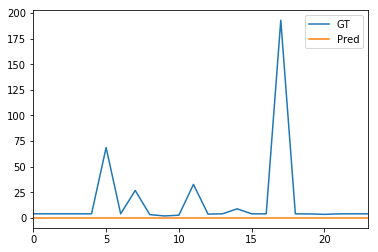

In [284]:
pd.Series(test_mw[1, :]).plot(label='GT')
#pd.Series(test_agg[1, :]).plot(label='GT')


pd.Series(model.predict(test_agg[1:2])[0, :24]).plot(label='Pred')




plt.legend()